<strong><b><font size="5">Análise Estatística e Modelagem Preditiva de Séries Temporais - Em Python</font></b></strong>

<strong><b><font size="5">Forecasting - Previsões Para Séries Temporais - Modelo Base</font></b></strong>

<strong><b><font size="5">Modelo de Previsão de Capacidade - Método Naive</font></b></strong>

In [1]:
%%sh
#pip -q install --upgrade pip
#pip -q install sagemaker awscli boto3 smdebug --upgrade
#pip install s3fs
#pip install matplotlib

In [2]:
# As novas versões do Pandas e Matplotlib trazem diversas mensagens de aviso ao desenvolvedor. Vamos desativar isso.
import sys
import warnings
import matplotlib.cbook
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

# Imports para manipulação de dados
import numpy as np
import pandas as pd
from datetime import datetime
#from pandas import Series

# Imports para visualização de dados
import matplotlib.pyplot as plt
import matplotlib as m

# Imports para métricas e performance do modelo
import math
from math import sqrt 
import sklearn
from sklearn.metrics import mean_squared_error 

# Imports para formatação dos gráficos
plt.style.use('fivethirtyeight')
m.rcParams['axes.labelsize'] = 14
m.rcParams['xtick.labelsize'] = 12
m.rcParams['ytick.labelsize'] = 12
m.rcParams['text.color'] = 'k'
from pylab import rcParams
rcParams['figure.figsize'] = 20, 6

In [3]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Data Science Academy" --iversions

ModuleNotFoundError: No module named 'watermark'

## Definição do Problema de Negócio

Previsão do número de óbitos de pacientes acima de 50 anos nas internações hospitalares - AIH.

## Conjunto de Dados

Usaremos conjuntos de dados que mostram o número de óbitos de pacientes acima de 50 anos nas internações hospitalares - AIH. Os dados tem registros dos anos de 2010 a 2020.

Será fornecido 1 dataset com 2 colunas, data e número de Óbitos. 

Usaremos conjuntos de dados que mostram o número de óbitos de pacientes acima de 50 anos nas internações hospitalares – AIH em Minas Gerais.

Os dados foram baixados do site do Datasus, módulo SIHSUS, tipo de arquivo RD- AIH Reduzida, anos de 2010 a 2020, UF MG, todos os meses:

http://www2.datasus.gov.br/DATASUS/index.php?area=0901&item=1&acao=25

Foi realizado o download de 129 arquivos, com 5.231.829 registros utilizados para preparar um arquivo csv com o agrupamento das internações das pessoas acima de 50 anos que vieram a óbito, perfazendo um total de 3.896 registros diários, 556 registros por semana (excluindo-se a primeira e a última), com data, número e valor total das internações, dados desde 2010.


In [6]:
import sagemaker
import pandas
import boto3
import s3fs
client = boto3.client('s3')
path = 's3://sagemaker-studio-us-east-1-564342467420/AIH/AIH.csv'

# Carrega os dados
dataframediario = pandas.read_csv(path)
dataframediario['Data'] = pd.to_datetime(dataframediario.Data, format = '%d/%m/%Y')
dataframediario = dataframediario.set_index('Data')
# Reamostrando os dados para frequência semanal - Usando o valor médio do número de óbitos de pacientes – AIH
dataframesemanal = dataframediario['QT_INTER'].resample('W').sum()
dataframe = dataframesemanal.to_frame()
dataframe.drop(dataframe.head(1).index,inplace=True) # drop first 1 rows
dataframe.drop(dataframe.tail(1).index,inplace=True) # drop last 1 rows


In [7]:
# Dados
dataframediario.head()

,QT_INTER
Data,
2010-01-01,70
2010-01-02,92
2010-01-03,104
2010-01-04,134
2010-01-05,117


In [8]:
dataframe.dtypes

QT_INTER    int64
dtype: object

In [9]:
dataframe.shape

(556, 1)

## Análise Exploratória dos Dados

Vamos preparar os dados e realizar diversas análises a fim de identificar possíveis padrões nos dados que ajudem mais tarde na criação do modelo preditivo.

In [10]:
# Refinamos os dados para o gráfico da série original

# A variável Count é nossa variável target (total de pessoas que usaram transporte)
target = dataframe['QT_INTER']

In [11]:
# Random seed 
np.random.seed(7)

In [12]:
# Refinamos os dados para o gráfico da série original

# A variável Count é nossa variável target (total de pessoas que usaram transporte)

target = dataframe['QT_INTER']

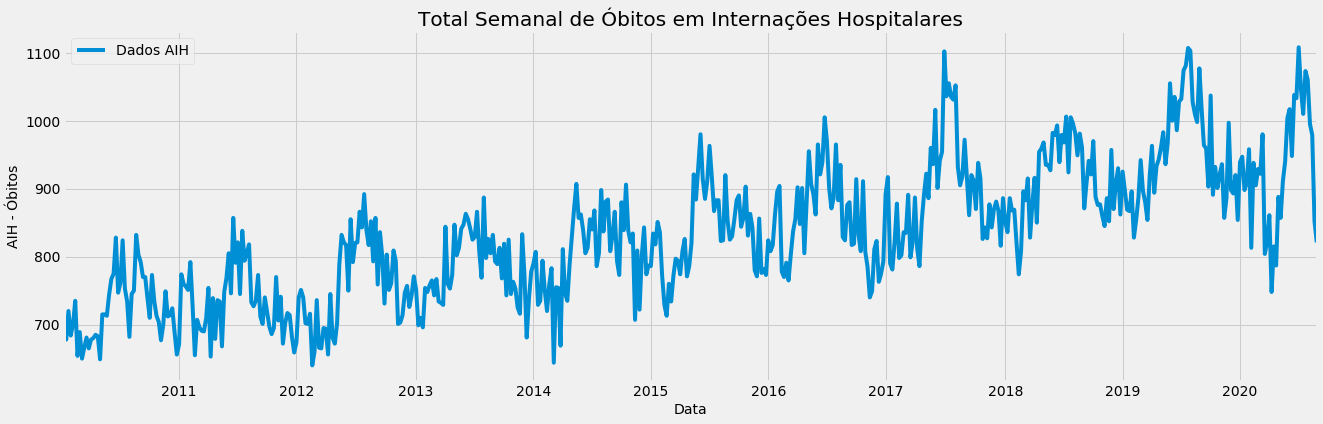

In [13]:
# Plot
target.plot(title = 'Total Semanal de Óbitos em Internações Hospitalares', fontsize = 14, label = 'Dados AIH') 
plt.xlabel("Data") 
plt.ylabel("AIH - Óbitos") 
plt.legend(loc = 'best') 
plt.show()

## Pré-Processamento

Vamos dividir os dados de treino e validação para treinar e validar a performance do modelo antes de usar os dados de teste.

In [14]:
# Os dados de treino serão divididos em dados de treino e teste.
# Observe que os registros são separados em ordem cronológica.
treino = dataframe.iloc[0:417]
teste = dataframe.iloc[417:]
print(len(treino), len(teste))

417 139


## Forecasting - Modelagem Preditiva Para Séries Temporais

Criaremos vários modelos para este problema que temos em mãos, aumentando o grau de complexidade a cada versão.

Mas toda caminhada deve começar com o primeiro passo. Vamos começar com o modelo preditivo mais simples que podemos criar.

### Método Naive

Técnica de estimativa na qual os dados reais do último período são usados como previsão desse período, sem ajustá-los ou tentar estabelecer fatores causais. É usado apenas para comparação com as previsões geradas pelas melhores técnicas (sofisticadas).

Naive = ingênuo

Não há técnica avançada aqui e apenas usamos como ponto de partida. Qualquer modelo mais avançado deve apresentar resultados superiores ao Método Naive.

In [15]:
# Criamos um array com os valores da variável target em treino
target = np.asarray(treino.QT_INTER)
target

array([ 697,  678,  720,  684,  700,  735,  654,  689,  650,  666,  681,
        665,  678,  680,  685,  683,  649,  715,  715,  713,  744,  767,
        775,  828,  747,  761,  824,  753,  734,  682,  745,  750,  832,
        803,  792,  770,  770,  739,  710,  773,  735,  713,  704,  677,
        700,  749,  712,  714,  724,  689,  656,  671,  774,  760,  756,
        751,  792,  727,  655,  707,  696,  691,  690,  709,  754,  653,
        739,  679,  736,  734,  668,  748,  769,  805,  746,  857,  791,
        821,  745,  838,  794,  805,  818,  733,  727,  735,  773,  712,
        701,  740,  718,  697,  686,  695,  770,  706,  741,  672,  702,
        717,  714,  682,  659,  674,  740,  751,  740,  702,  701,  716,
        640,  660,  736,  666,  665,  695,  694,  656,  745,  681,  672,
        702,  789,  832,  821,  817,  750,  855,  792,  820,  821,  866,
        843,  892,  839,  817,  852,  793,  857,  759,  836,  801,  731,
        803,  751,  761,  809,  794,  701,  703,  7

In [16]:
# Cria uma cópia dos dados de validação
predict = teste.copy()
predict.head()

,QT_INTER
Data,
2018-01-07,851
2018-01-14,836
2018-01-21,886
2018-01-28,868
2018-02-04,869


In [17]:
# Previsão

# Veja como o método é mesmo Naive
# Os dados reais (de treino) são usados como previsão para os dados de validação, 
# sem ajustá-los ou tentar estabelecer fatores causais.

# Sim, isso é o Método Naive!
predict['previsao_naive'] = target[len(target) - 1] 

In [18]:
# Colocamos lado a lado, valor real e valor "previsto"
predict[['QT_INTER', 'previsao_naive']].head()

,QT_INTER,previsao_naive
Data,,
2018-01-07,851,886
2018-01-14,836,886
2018-01-21,886,886
2018-01-28,868,886
2018-02-04,869,886


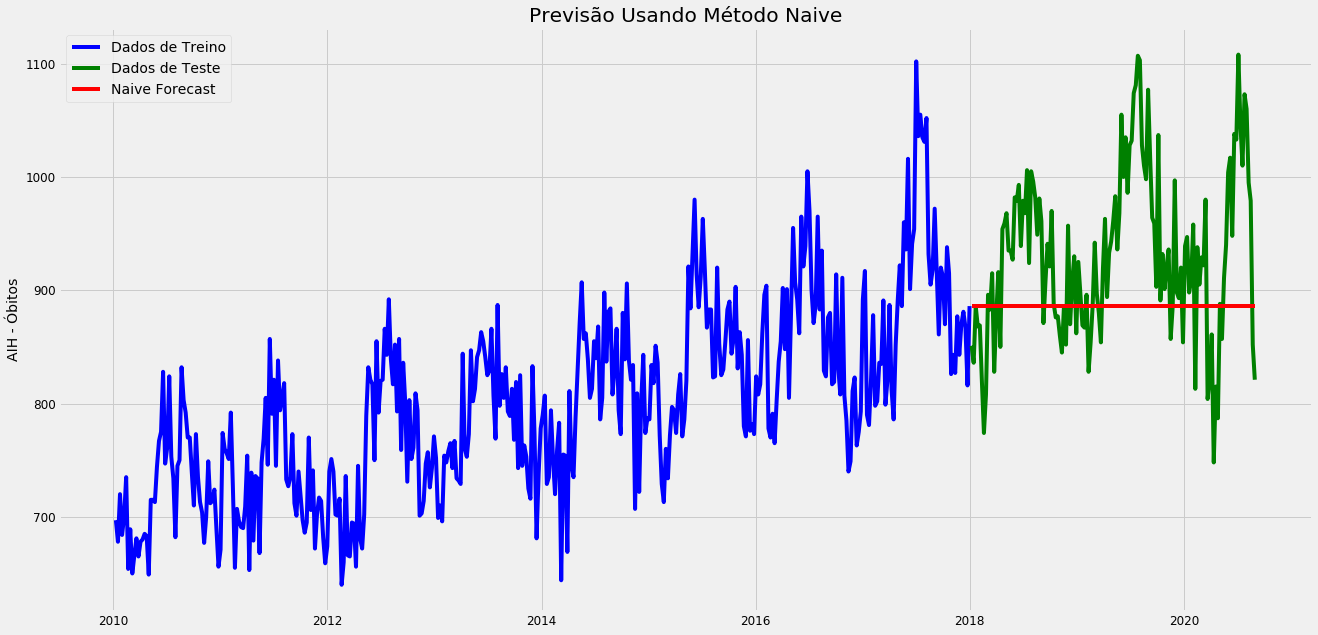

In [19]:
# Plot
plt.figure(figsize = (20, 10))
plt.title("Previsão Usando Método Naive") 
plt.plot(treino.index, treino['QT_INTER'], label = 'Dados de Treino', color = 'blue') 
plt.plot(teste.index, teste['QT_INTER'], label = 'Dados de Teste', color = 'green') 
plt.plot(predict.index, predict['previsao_naive'], label = 'Naive Forecast', color = 'red') 
plt.ylabel('AIH - Óbitos')
plt.legend(loc = 'upper left') 
plt.show()

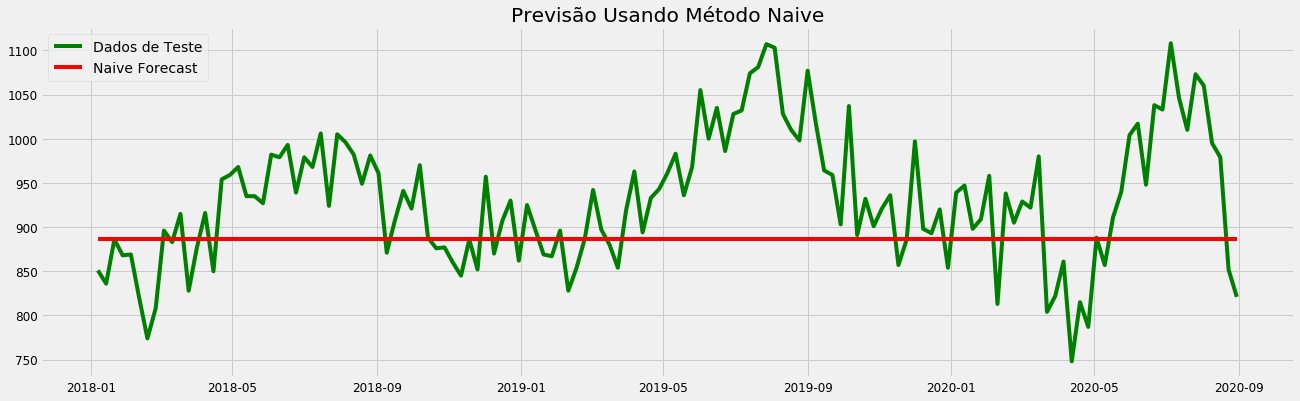

In [20]:
# Plot
plt.figure(figsize = (20, 6))
plt.title("Previsão Usando Método Naive") 
plt.plot(teste.index, teste['QT_INTER'], label = 'Dados de Teste', color = 'green') 
plt.plot(predict.index, predict['previsao_naive'], label = 'Naive Forecast', color = 'red') 
plt.legend(loc = 'best') 
plt.show()

Pronto! Temos a previsão da nossa série! Você apresentaria esse modelo ao investidor disposto a investir no seu negócio? Espero que não! 

Então vamos trabalhar para criar um modelo robusto nas próximas aulas. Mas antes, vamos calcular a taxa de erro do modelo. 

In [21]:
# Define valor real e valor previsto
y_true = predict.QT_INTER
y_pred = predict.previsao_naive

In [22]:
# Calcula o erro usando RMSE (Root Mean Squared Error)
metrica_rmse = sqrt(mean_squared_error(y_true, y_pred)) 
print(metrica_rmse) 

86.17770664332022


Todas as aulas deste curso podem ser encontradas na timeline da Comunidade no portal da DSA: www.datascienceacademy.com.br

# Fim